<a href="https://colab.research.google.com/github/jackshee/LectinBinding/blob/main/ESM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook only runs in Google Colab to leverage GPU access. It accesses the pretrained `ESM2 model` published by Meta via the `HuggingFace` API and encodes known lectins in the glycan microarray dataset available through `glycowork` by converting an amino acid sequence representation e.g. a `String` (AACTNTSCSGHGECVETINNYTCKCDPGFSGLKCEQ) to a vector representation (protein sequence embedding). 

It is important to note that accessing `ESM2` this way requires custom fine tuning of the model if a new model architecture is defined. However, for our purposes, we use the pretrained `LectinOracle` model that has been *already* fine-tuned this way. 

For the sake of reproducibility, and further customisation, I tried retraining my own version of `LectinOracle` and got "similar" sets of embeddings. However there is always stochasticity from training without random seed initialised.

# Colab Set up

In [ ]:
# Mounting google drive, required to save embeddings for downstream analysis
from google.colab import drive
drive.mount('/content/drive')

# Uncomment below to install dependencies on allocated machine when connecting to new instance. 
# Note: torch comes preinstalled in Colab environment
!pip install glycowork
!pip install transformers
!pip install 'glycowork[ml]'

# Accessing ESM2 via Hugging Face

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 1280, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 1280, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-32): 33 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmInter

# Loading Dataset from Glycowork and Converting Sequences to Embeddings

In [ ]:
from glycowork.glycan_data.loader import glycan_binding
import pickle
import torch
from transformers import AutoTokenizer, AutoModel


# Fetch all unique protein targets
all_prots = list(set(glycan_binding.target.tolist()))
batch_size = 10

# Path to save the pickle file
filename = '/content/drive/My Drive/esm2_embeddings_full.pkl'

# Function to process a batch of proteins
def process_batch(proteins):
    inputs = tokenizer(proteins, padding=True, max_length=1000, truncation=True, return_tensors="pt")
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state

    return {prot: last_hidden_states[i, 1:len(prot) + 1].mean(0).cpu().numpy().tolist() for i, prot in enumerate(proteins)}

# Iterate over the proteins in batches and save the results
with open(filename, 'ab') as file:  # 'ab' for appending in binary mode
    for i in range(0, len(all_prots), batch_size):
        batch_prots = all_prots[i:i + batch_size]
        prot_dic = process_batch(batch_prots)
        pickle.dump(prot_dic, file)

print("All data processed and saved successfully.")


# Checking Saved Embeddings

In [ ]:
import pickle 

# Path to where embeddings are stored
filename = '/content/drive/My Drive/esm2_embeddings_full.pkl'

# Initialize an empty dictionary to hold all the data
prot_dic = {}

# Open the pickle file and read from it
with open(filename, 'rb') as file:
    while True:
        try:
            # Load the data from the file and update the main dictionary
            data = pickle.load(file)
            prot_dic.update(data)
        except EOFError:
            # End of file reached
            break

# Check the loaded data
print(f"Loaded data for {len(prot_dic)} proteins.")

# Optionally, print some of the data to verify
for protein, embedding in list(prot_dic.items())[:5]:
    print(protein, embedding[:10])  # Print first 10 elements of each protein embedding for brevity


There are 1392 glycan binding proteins in the glycan binding array dataset. These are the set of known existing glycan binding proteins. The question is: **amongst these known proteins, which ones have the highest affinity for sialyl-lewis-A?** Answering this question will form a starting point to prototype the nanobiosensor before further optimisation of the signal. This is just to form the proof of concept and MVP.  

In [ ]:
len(prot_dic)

1392

# Using LectinOracle to predict Binding Affinity

In [ ]:
import numpy as np
import pandas as pd
import torch
from glycowork.glycan_data.loader import lib, unwrap, build_custom_df, df_glycan, glycan_binding
from glycowork.ml.processing import dataset_to_dataloader
from glycowork.motif.tokenization import prot_to_coded

# making predictions for human glycans
df_species = build_custom_df(df_glycan, 'df_species')
glyc = df_species.loc[df_species.Species == 'Homo_sapiens'].glycan.tolist()
glyc = list(set(glyc))

# making predictions for disease state glyc
df_disease = build_custom_df(df_glycan, 'df_disease')
df_panc = df_disease[df_disease['disease_association'] == 'pancreatic_cancer']
df_panc = df_panc.drop_duplicates(subset = 'glycan')
biomarkers = df_panc.glycan.tolist()

# Choosing the right computing architecture
device = "cuda" if torch.cuda.is_available() else "cpu"

# load model
from glycowork.ml.models import prep_model

LeOr = prep_model('LectinOracle', 1, trained = True)
LeOr.to(device)
# LeOr_flex = prep_model('LectinOracle_flex', 1, trained = True)


LectinOracle(
  (conv1): GraphConv(128, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (item_embedding): Embedding(2367, 128)
  (prot_encoder1): Linear(in_features=1280, out_features=400, bias=True)
  (prot_encoder2): Linear(in_features=400, out_features=128, bias=True)
  (bn_prot1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_prot2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp_prot1): Dropout(p=0.2, inplace=False)
  (dp_prot2): Dropout(p=0.1, inplace=False)
  (act_prot1): LeakyReLU(negative_slope=0.01)
  (act_prot2): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.5, inplace=False)
  (act1): LeakyReLU(negative_slope=0.01)
  (sigmoid): SigmoidRange()
)

In [ ]:
def get_multi_pred(prot, glycans, model, prot_dic=prot_dic,
                   background_correction = False, correction_df = None,
                   batch_size = 128, libr = None, flex = False, mode = 'rep'):
  """Inner function to actually get predictions for lectin-glycan binding from LectinOracle-type model\n
  | Arguments:
  | :-
  | prot (string): protein amino acid sequence
  | glycans (list): list of glycans in IUPACcondensed
  | model (PyTorch object): trained LectinOracle-type model
  | prot_dic (dictionary): dictionary of type protein sequence:ESM1b representation
  | background_correction (bool): whether to correct predictions for background; default:False
  | correction_df (dataframe): background prediction for (ideally) all provided glycans; default:None
  | batch_size (int): change to batch_size used during training; default:128
  | libr (dict): dictionary of form glycoletter:index
  | flex (bool): depends on whether you use LectinOracle (False) or LectinOracle_flex (True); default:False\n
  | Returns:
  | :-
  | Returns dataframe of glycan sequences and predicted binding to prot
  """
  if libr is None:
      libr = lib
  # Preparing dataset for PyTorch
  if flex:
      prot = prot_to_coded([prot])
      feature = prot * len(glycans)
  else:
      rep = prot_dic.get(prot, "new protein, no stored embedding")
      feature = [rep] * len(glycans)
  train_loader = dataset_to_dataloader(glycans, [0.99]*len(glycans),
                                         libr = libr, batch_size = batch_size,
                                         shuffle = False, extra_feature = feature)
  model = model.eval()
  res = []
  # Get predictions for each mini-batch
  for k in train_loader:
    x, y, edge_index, prot, batch = k.labels, k.y, k.edge_index, k.train_idx, k.batch
    x, y, edge_index, prot, batch = x.to(device), y.to(device), edge_index.to(device), prot.view(max(batch) + 1, -1).float().to(device), batch.to(device)
    pred, reps, _ = model(prot, x, edge_index, batch, inference=True)
    if mode == 'rep':
      res.append(reps)
    else:
      res.append(pred)
  res = unwrap([res[k].detach().cpu().numpy() for k in range(len(res))])

  return res

As noted, if we store `prot_rep` (protein representations) from the pretrained `LectinOracle`, we will get a different set of embeddings that have been fine tuned during training on this glycan array dataset. 

Since we are only interested in the binding affinities of known glycan binding proteins (lectins), we will just use the set of embeddings obtained from `ESM2` directly but use the `LectinOracle` which combines ESM2 representations (so they have been fine tuned) to predict binding affinities. The assumption is that the model is good enough at prediction such that the relative ranking of affinities between ESM2 embeddings and fine-tuned ESM2 embeddings should be similar. 

In [ ]:
#getting learned protein represenations from LectinOracle
# DO NOT run this cell, will overwrite already saved embeddings, this takes a long time to execute
prot_reps = {}
binding_pred = {}
for i, seq in enumerate(glycan_binding.target.tolist()[:2]):
  if(i%10 == 0):
    print(i)
  prot_reps[seq] = np.array(get_multi_pred(seq, [glyc[0]], LeOr)).squeeze()
  binding_pred[seq] = unwrap(get_multi_pred(seq, glyc, LeOr, mode='pred'))

# Uncomment lines below to get the fine-tuned embedding representations which happen to be stored by the model during its training for convenient access. Note however THIS TAKES A LONG TIME TO RUN! I have run this once already and saved the data.
# pd.DataFrame(prot_reps).T.to_csv('/content/drive/My Drive/LeOr_embeddings.csv')
# motif_pred = pd.DataFrame(binding_pred).T
# motif_pred.columns = glyc
# motif_pred.to_csv('/content/drive/My Drive/human_glycan_motif_predicted.csv')

# Visualisation of Lectin Embeddings

The embedding vector which is in $\mathbb{R}^{128}$ must be projected to $\mathbb{R}^2$ for visualisation. We use tSNE to do this which assumes that local distances between points are conserved. Therefore, although the visualisation may appear different each time, relative distance between points should be preserved (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). If we then use colours to indicate strength of binding affinity, we should see dense regions of colour representing the family of lectins that have high affinity for the glycan epitope of interest.

Ensure that `scikit-learn`, `matplotlibt`, `seaborn`, `pandas`, `numpy` are all installed as dependencies if working locally. I produced these plots in Google Colab so these were preinstalled.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

df_prot_reps = pd.read_csv('/content/drive/My Drive/LeOr_embeddings.csv', index_col=0)

df_pred = pd.read_csv('/content/drive/My Drive/human_glycan_motif_predicted.csv', index_col=0)

# visualisation of 128 dimensional LeOr representations using TSNE

motif_pred_dict= df_pred.to_dict()
glyc = list(df_pred.columns)

X = df_prot_reps.values
X_embedded = TSNE(random_state=42).fit_transform(X)

In [ ]:
# Uncomment and run this cell when working in a new session for just visualisation
# !pip install glycowork
# !pip install 'glycowork[draw]'

The following cell defines the motif of interest (aka. glycan epitope Sialyl-Lewis-A). This is the motif that is present on CA19-9 (the current gold-standard biomarker for diagnosis of pancreatic cancer). HOWEVER, it is important to note that the glycan motif is not unique to CA19-9. In fact, glycosylation is a general post-translational modification of proteins. The question is can we still detect upregulated levels of CA19-9 using upregulated sLeA as a proxy? We would need to test the specificity of the biosensor with other biomolecules that have similar structures to sLeA and CA19-9. The line and definition of what is CA19-9 starts becoming blurry.

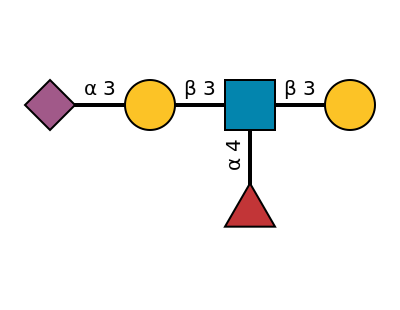

In [ ]:
from glycowork.motif.draw import GlycoDraw
from glycowork.glycan_data.loader import unwrap

# the glycan structure of Sialyl-Lewis-A
motif='Neu5Ac(a2-3)Gal(b1-3)[Fuc(a1-4)]GlcNAc(b1-3)Gal'

if motif in df_pred.columns:
  binding_val = list(motif_pred_dict[motif].values())
else:
  print('motif not in precomputed file')
  binding_val = unwrap([unwrap(get_multi_pred(seq, [motif], LeOr, mode='pred')) for seq in list(df_pred.index)])

GlycoDraw(motif)

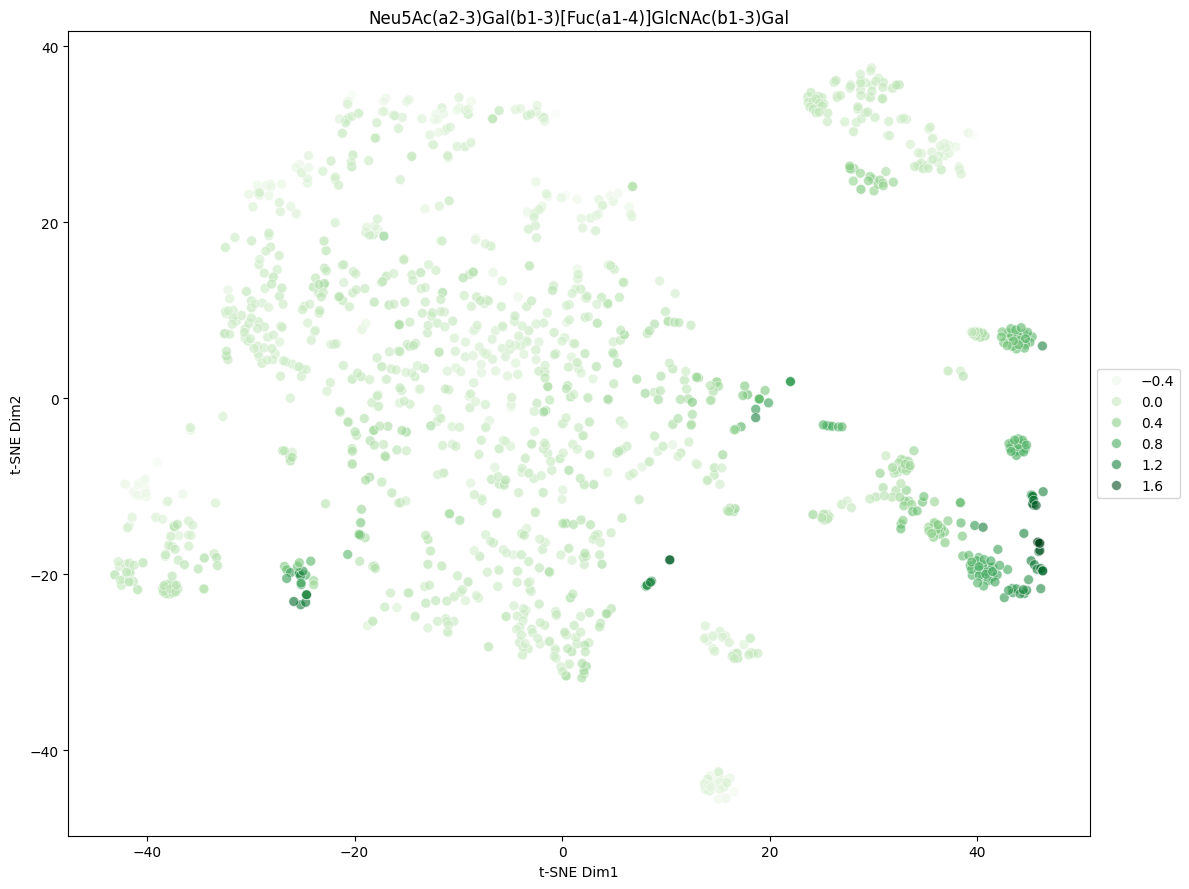

In [ ]:

plt.figure(figsize = (12, 9))

sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], s = 50, alpha = 0.6,
                hue = binding_val, palette = 'Greens')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title(motif)
plt.tight_layout()
plt.show()

From the plot above, we see a cluster of lectins that have high specificity for sLeA. We will use these a starting a point for experimentation. 

# References 

Lin, Z., Akin, H., Rao, R., Hie, B., Zhu, Z., Lu, W., Smetanin, N., Verkuil, R., Kabeli, O., Shmueli, Y., dos Santos Costa, A., Fazel-Zarandi, M., Sercu, T., Candido, S., Rives, A., 2023. Evolutionary-scale prediction of atomic-level protein structure with a language model. Science 379, 1123–1130. https://doi.org/10.1126/science.ade2574

Lundstrøm, J., Korhonen, E., Lisacek, F., Bojar, D., 2022. LectinOracle: A Generalizable Deep Learning Model for Lectin–Glycan Binding Prediction. Advanced Science 9, 2103807. https://doi.org/10.1002/advs.202103807

Bojar, D., Lisacek, F., 2022. Glycoinformatics in the Artificial Intelligence Era. Chem. Rev. 122, 15971–15988. https://doi.org/10.1021/acs.chemrev.2c00110
